In [1]:
!mkdir /home/rohit/fastai/courses/dl2/data/pools/falsecolorcomposite_noaspect_neg
!mkdir /home/rohit/fastai/courses/dl2/data/pools/falsecolorcomposite_noaspect_neg/images

mkdir: cannot create directory ‘/home/rohit/fastai/courses/dl2/data/pools/falsecolorcomposite_noaspect_neg’: File exists
mkdir: cannot create directory ‘/home/rohit/fastai/courses/dl2/data/pools/falsecolorcomposite_noaspect_neg/images’: File exists


In [2]:
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame

In [3]:
gis = GIS('https://deldev.maps.arcgis.com', 'demo_deldev', 'P@ssword123')

In [4]:
shp = 'data/pools/SwimmingPools180605b.shp'

In [5]:
df = SpatialDataFrame.from_featureclass(shp)

In [6]:
df.head()

,index,Id,SHAPE
0,0,0,"{'x': -13042553.9341, 'y': 4033058.5876}"
1,1,0,"{'x': -13042558.4311, 'y': 4033081.0722000003}"
2,2,0,"{'x': -13042605.4989, 'y': 4033095.462399997}"
3,3,0,"{'x': -13042621.687800001, 'y': 4033120.345399..."
4,4,0,"{'x': -13042610.5954, 'y': 4033014.8175000027}"


<Item title:"USA NAIP Imagery: False Color" type:Imagery Layer owner:esri>
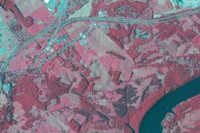

In [7]:
from arcgis.raster import ImageryLayer
naip = gis.content.search('title:USA NAIP Imagery False Color', 'Imagery Layer', outside_org=True)[1]
naip

In [8]:
from arcgis.raster.functions import apply

naiplayer = naip.layers[0]
naipfalse = apply(naiplayer, 'FalseColorComposite')

In [11]:
df['X'] = df.geometry.apply(lambda pt: pt['x'] )
df['Y'] = df.geometry.apply(lambda pt: pt['y'] )

In [12]:
df.head()

,index,Id,SHAPE,X,Y
0,0,0,"{'x': -13042553.9341, 'y': 4033058.5876}",-1.304255e+07,4.033059e+06
1,1,0,"{'x': -13042558.4311, 'y': 4033081.0722000003}",-1.304256e+07,4.033081e+06
2,2,0,"{'x': -13042605.4989, 'y': 4033095.462399997}",-1.304261e+07,4.033095e+06
3,3,0,"{'x': -13042621.687800001, 'y': 4033120.345399...",-1.304262e+07,4.033120e+06
4,4,0,"{'x': -13042610.5954, 'y': 4033014.8175000027}",-1.304261e+07,4.033015e+06


In [13]:
df.dtypes

index      int64
Id         int64
SHAPE     object
X        float64
Y        float64
dtype: object

In [15]:
df.shape

(2137, 5)

In [19]:
import random

tilemapping = {}

for index, row in df.iterrows():
    imgid = row['index']
    if imgid % 100 == 0:
        print(imgid)
    try:
        for i in range(50):    
            filename = str(imgid).zfill(4) + '_' + str(i).zfill(2) + '.jpg'        
            xmid = row['X'] + random.randint(-45, 45)
            ymid = row['Y'] + random.randint(-45, 45)

            xmin, ymin = xmid - 50, ymid - 50
            xmax, ymax = xmid + 50, ymid + 50

            ext = {'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax, 'spatialReference':3857}
            naipfalse.export_image(ext, image_sr=df.sr,
                                  bbox_sr=3857, size=[224,224], f='image', export_format='jpg', adjust_aspect_ratio=False,
                                  save_folder=r'/home/rohit/fastai/courses/dl2/data/pools/falsecolorcomposite_noaspect_neg/images',
                                  save_file=filename)

            centers = []
            for index1, row1 in df.loc[(df.X > xmin) & (df.X < xmax) & \
                                       (df.Y > ymin) & (df.Y < ymax)].iterrows():
                x, y = row1['X'], row1['Y']
                x = (x - xmin) / (xmax - xmin)
                y = (y - ymin) / (ymax - ymin)
                centers.append((x,y))

            if len(centers) > 0:
                tilemapping[filename] = centers
    except:
        
        print('Error getting ', imgid)
    

1500
1600
1700
1800
1900
2000
2100


In [20]:
import pickle

pickle.dump(tilemapping, open('data/pools/falsecolorcomposite_noaspect_neg/tilemapping.pkl', 'wb'))